##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fitting Generalized Linear Mixed-effects Models Using Variational Inference

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/Linear_Mixed_Effects_Model_Variational_Inference"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Model_Variational_Inference.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Model_Variational_Inference.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/Linear_Mixed_Effects_Model_Variational_Inference.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [ ]:
#@title Install { display-mode: "form" }
TF_Installation = 'System' #@param ['TF Nightly', 'TF Stable', 'System']

if TF_Installation == 'TF Nightly':
  !pip install -q --upgrade tf-nightly
  print('Installation of `tf-nightly` complete.')
elif TF_Installation == 'TF Stable':
  !pip install -q --upgrade tensorflow
  print('Installation of `tensorflow` complete.')
elif TF_Installation == 'System':
  pass
else:
  raise ValueError('Selection Error: Please select a valid '
                   'installation option.')

In [ ]:
#@title Install { display-mode: "form" }
TFP_Installation = "System" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

## Abstract



In this colab we demonstrate how to fit a generalized linear mixed-effects model using variational inference in TensorFlow Probability.


## Model Family

[Generalized linear mixed-effect models](https://en.wikipedia.org/wiki/Generalized_linear_mixed_model) (GLMM) are similar to [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model) (GLM) except that they incorporate a sample specific noise into the predicted linear response.  This is useful in part because it allows rarely seen features to share information with more commonly seen features.



As a generative process, a Generalized Linear Mixed-effects Model (GLMM) is characterized by:

$$
\begin{align}
\text{for } & r = 1\ldots R:  \hspace{2.45cm}\text{# for each random-effect group}\\
 &\begin{aligned}
  \text{for } &c = 1\ldots |C_r|:  \hspace{1.3cm}\text{# for each category ("level") of group $r$}\\
  &\begin{aligned}
    \beta_{rc}
    &\sim \text{MultivariateNormal}(\text{loc}=0_{D_r}, \text{scale}=\Sigma_r^{1/2})
  \end{aligned}
\end{aligned}\\\\
\text{for } & i = 1 \ldots N:  \hspace{2.45cm}\text{# for each sample}\\
&\begin{aligned}
  &\eta_i = \underbrace{\vphantom{\sum_{r=1}^R}x_i^\top\omega}_\text{fixed-effects} + \underbrace{\sum_{r=1}^R z_{r,i}^\top \beta_{r,C_r(i) }}_\text{random-effects} \\
  &Y_i|x_i,\omega,\{z_{r,i} , \beta_r\}_{r=1}^R \sim \text{Distribution}(\text{mean}= g^{-1}(\eta_i))
\end{aligned}
\end{align}
$$

where:

$$
\begin{align}
R &= \text{number of random-effect groups}\\
|C_r| &= \text{number of categories for group $r$}\\
N &= \text{number of training samples}\\
x_i,\omega &\in \mathbb{R}^{D_0}\\
D_0 &= \text{number of fixed-effects}\\
C_r(i) &= \text{category (under group $r$) of the $i$th sample}\\
z_{r,i} &\in \mathbb{R}^{D_r}\\
D_r &= \text{number of random-effects associated with group $r$}\\
\Sigma_{r} &\in \{S\in\mathbb{R}^{D_r \times D_r} : S \succ 0 \}\\
\eta_i\mapsto g^{-1}(\eta_i) &= \mu_i, \text{inverse link function}\\
\text{Distribution} &=\text{some distribution parameterizable solely by its mean}
\end{align}
$$

In other words, this says that every category of each group is associated with a sample, $\beta_{rc}$,  from a multivariate normal. Although the $\beta_{rc}$ draws are always independent, they are only indentically distributed for a group $r$: notice there is exactly one $\Sigma_r$ for each $r\in\{1,\ldots,R\}$.

When affinely combined with a sample's group's features ($z_{r,i}$), the result is sample-specific noise on the $i$-th predicted linear response (which is otherwise $x_i^\top\omega$).

When we estimate $\{\Sigma_r:r\in\{1,\ldots,R\}\}$ we're essentially estimating the amount of noise a random-effect group carries which would otherwise drown out the signal present in $x_i^\top\omega$.

There are a variety of options for the $\text{Distribution}$ and [inverse link function](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function), $g^{-1}$. Common choices are:
- $Y_i\sim\text{Normal}(\text{mean}=\eta_i, \text{scale}=\sigma)$,
- $Y_i\sim\text{Binomial}(\text{mean}=n_i \cdot \text{sigmoid}(\eta_i), \text{total_count}=n_i)$, and, 
- $Y_i\sim\text{Poisson}(\text{mean}=\exp(\eta_i))$.

For more possibilities, see the [`tfp.glm`](https://github.com/tensorflow/probability/tree/main/tensorflow_probability/python/glm) module.

## Variational Inference

Unfortunately, finding the maximum likelihood estimates of the parameters $\beta,\{\Sigma_r\}_r^R$ entails a non-analytical integral. To circumvent this problem, we instead 
1. Define a parameterized family of distributions (the "surrogate density"), denoted $q_{\lambda}$ in the appendix.
2. Find parameters $\lambda$ so that $q_{\lambda}$ is close to our true target denstiy.

The family of distributions will be independent Gaussians of the proper dimensions, and by "close to our target density", we will mean "minimizing the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)". See, for example [Section 2.2 of "Variational Inference: A Review for Statisticians"](https://arxiv.org/abs/1601.00670) for a well-written derivation and motivation. In particular, it shows that minimizing the K-L divergence is equivalent to minimizing the negative evidence lower bound (ELBO).

## Toy Problem

[Gelman et al.'s (2007) "radon dataset"](http://www.stat.columbia.edu/~gelman/arm/) is a dataset sometimes used to demonstrate approaches for regression. (E.g., this closely related [PyMC3 blog post](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/).) The radon dataset contains indoor measurements of Radon taken throughout the United States. [Radon](https://en.wikipedia.org/wiki/Radon) is naturally ocurring radioactive gas which is [toxic](http://www.radon.com/radon_facts/) in high concentrations.

For our demonstration, let's suppose we're interested in validating the hypothesis that Radon levels are higher in households containing a basement. We also suspect Radon concentration is related to soil-type, i.e., geography matters.

To frame this as an ML problem, we'll try to predict log-radon levels based on a linear function of the floor on which the reading was taken.  We'll also use the county as a random-effect and in so doing account for variances due to geography. In other words, we'll use a [generalized linear mixed-effect model](https://en.wikipedia.org/wiki/Generalized_linear_mixed_model).

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
from six.moves import urllib

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_context('notebook')
import tensorflow_datasets as tfds

import tensorflow as tf
import tf_keras

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

We will also do a quick check for availablility of a GPU:

In [ ]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print("We'll just use the CPU for this run.")
else:
  print('Huzzah! Found GPU: {}'.format(tf.test.gpu_device_name()))

We'll just use the CPU for this run.


### Obtain Dataset:

We load the dataset from TensorFlow datasets and do some light preprocessing.

In [ ]:
def load_and_preprocess_radon_dataset(state='MN'):
  """Load the Radon dataset from TensorFlow Datasets and preprocess it.
  
  Following the examples in "Bayesian Data Analysis" (Gelman, 2007), we filter
  to Minnesota data and preprocess to obtain the following features:
  - `county`: Name of county in which the measurement was taken.
  - `floor`: Floor of house (0 for basement, 1 for first floor) on which the
    measurement was taken.

  The target variable is `log_radon`, the log of the Radon measurement in the
  house.
  """
  ds = tfds.load('radon', split='train')
  radon_data = tfds.as_dataframe(ds)
  radon_data.rename(lambda s: s[9:] if s.startswith('feat') else s, axis=1, inplace=True)
  df = radon_data[radon_data.state==state.encode()].copy()

  df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)
  # Make county names look nice. 
  df['county'] = df.county.apply(lambda s: s.decode()).str.strip().str.title()
  # Remap categories to start from 0 and end at max(category).
  df['county'] = df.county.astype(pd.api.types.CategoricalDtype())
  df['county_code'] = df.county.cat.codes
  # Radon levels are all positive, but log levels are unconstrained
  df['log_radon'] = df['radon'].apply(np.log)

  # Drop columns we won't use and tidy the index 
  columns_to_keep = ['log_radon', 'floor', 'county', 'county_code']
  df = df[columns_to_keep].reset_index(drop=True)
 
  return df

df = load_and_preprocess_radon_dataset()
df.head()

,log_radon,floor,county,county_code
0,0.788457,1,Aitkin,0
1,0.788457,0,Aitkin,0
2,1.064711,0,Aitkin,0
3,0.000000,0,Aitkin,0
4,1.131402,0,Anoka,1


### Specializing the GLMM Family

In this section, we specialize the GLMM family to the task of predicting radon levels. To do this, we first consider the fixed-effect special case of a GLMM:
$$
\mathbb{E}[\log(\text{radon}_j)] = c + \text{floor_effect}_j
$$

This model posits that the log radon in observation $j$ is (in expectation) governed by the floor the $j$th reading is taken on, plus some constant intercept. In pseudocode, we might write 

    def estimate_log_radon(floor):
        return intercept + floor_effect[floor]

there's a weight learned for every floor and a universal `intercept` term. Looking at the radon measurements from floor 0 and 1, it looks like this might be a good start:

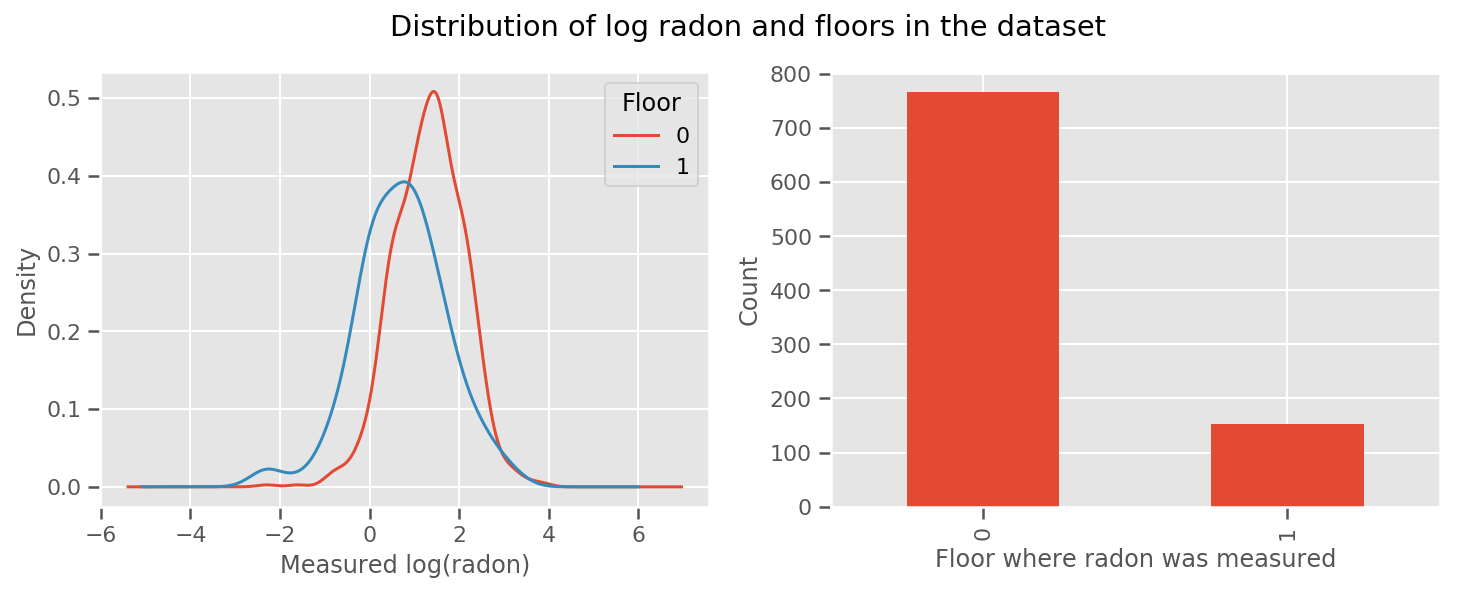

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))
df.groupby('floor')['log_radon'].plot(kind='density', ax=ax1);
ax1.set_xlabel('Measured log(radon)')
ax1.legend(title='Floor')

df['floor'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_xlabel('Floor where radon was measured')
ax2.set_ylabel('Count')
fig.suptitle("Distribution of log radon and floors in the dataset");

To make the model a little more sophisticated, including something about geography is probably even better: radon is part of the decay chain of uranium, which may be present in the ground, so geography seems key to account for.

$$
\mathbb{E}[\log(\text{radon}_j)] = c + \text{floor_effect}_j + \text{county_effect}_j
$$

Again, in pseudocode, we have

    def estimate_log_radon(floor, county):
        return intercept + floor_effect[floor] + county_effect[county]
   
the same as before except with a county-specific weight.

Given a sufficiently large training set, this is a reasonable model.  However, given our data from Minnesota, we see that there's there's a large number of counties with a small number of measurements. For example, 39 out of 85 counties have fewer than five observations. 

This motivates sharing statistical strength between all our observations, in a way that converges to the above model as the number of observations per county increases.

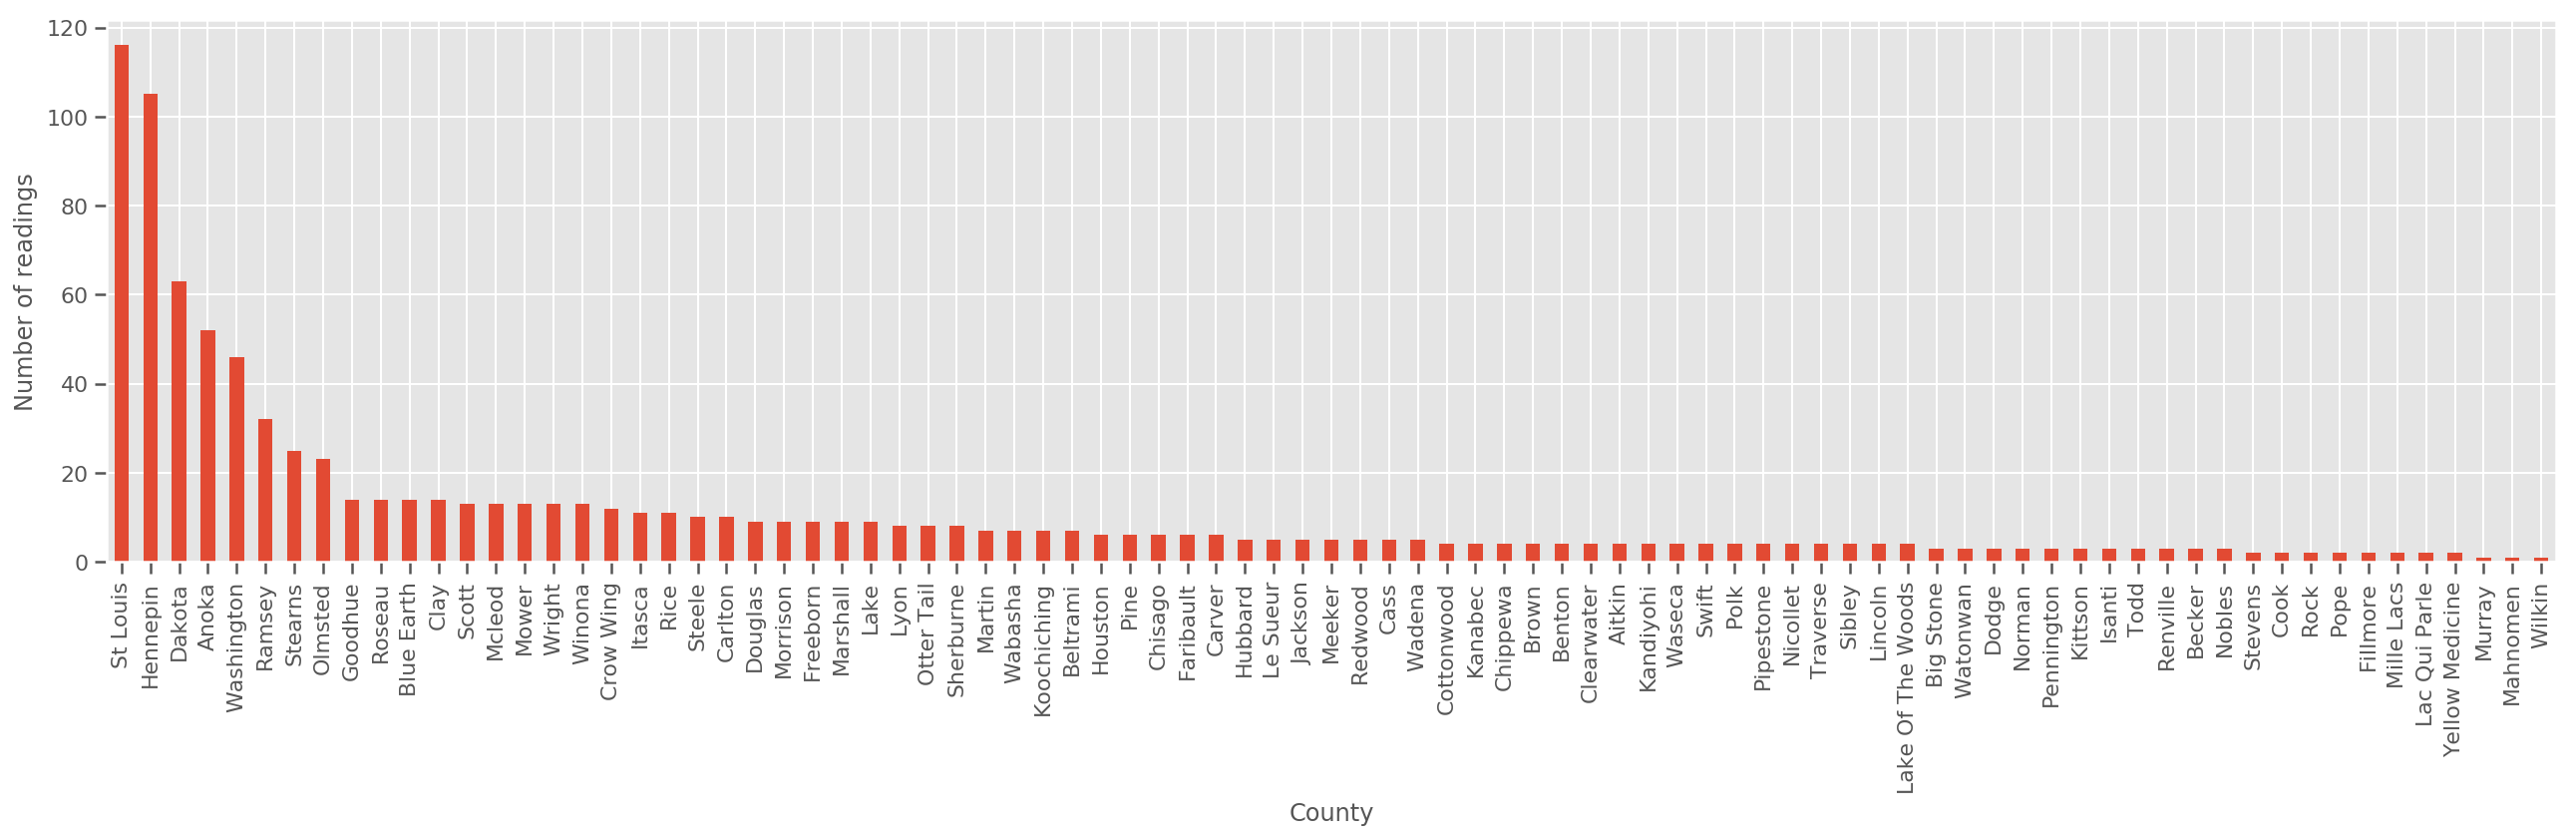

In [ ]:
fig, ax = plt.subplots(figsize=(22, 5));
county_freq = df['county'].value_counts()
county_freq.plot(kind='bar', ax=ax)
ax.set_xlabel('County')
ax.set_ylabel('Number of readings');

If we fit this model, the `county_effect` vector would likely end up memorizing the results for counties which had only a few training samples, perhaps overfitting and leading to poor generalization.

GLMM's offer a happy middle to the above two GLMs.  We might consider fitting

$$
\log(\text{radon}_j) \sim c + \text{floor_effect}_j + \mathcal{N}(\text{county_effect}_j, \text{county_scale})
$$

This model is the same as the first, but we have fixed our likelihood to be a normal distribution, and will share the variance across all counties through the (single) variable `county_scale`.  In pseudocode,

    def estimate_log_radon(floor, county):
        county_mean = county_effect[county]
        random_effect = np.random.normal() * county_scale + county_mean
        return intercept + floor_effect[floor] + random_effect

We will infer the joint distribution over `county_scale`, `county_mean`, and the `random_effect` using our observed data. The global `county_scale` allows us to share statistical strength across counties: those with many observations provide a hit at the variance of counties with few observations. Furthermore, as we gather more data, this model will converge to the model without a pooled scale variable - even with this dataset, we will come to similar conclusions about the most observed counties with either model.

## Experiment

We'll now try to fit the above GLMM using variational inference in TensorFlow. First we'll split the data into features and labels.

In [ ]:
features = df[['county_code', 'floor']].astype(int)
labels = df[['log_radon']].astype(np.float32).values.flatten()

### Specify Model

In [ ]:
def make_joint_distribution_coroutine(floor, county, n_counties, n_floors):

  def model():
    county_scale = yield tfd.HalfNormal(scale=1., name='scale_prior')
    intercept = yield tfd.Normal(loc=0., scale=1., name='intercept')
    floor_weight = yield tfd.Normal(loc=0., scale=1., name='floor_weight')
    county_prior = yield tfd.Normal(loc=tf.zeros(n_counties),
                                    scale=county_scale,
                                    name='county_prior')
    random_effect = tf.gather(county_prior, county, axis=-1)

    fixed_effect = intercept + floor_weight * floor
    linear_response = fixed_effect + random_effect
    yield tfd.Normal(loc=linear_response, scale=1., name='likelihood')
  return tfd.JointDistributionCoroutineAutoBatched(model)

joint = make_joint_distribution_coroutine(
    features.floor.values, features.county_code.values, df.county.nunique(),
    df.floor.nunique())

# Define a closure over the joint distribution 
# to condition on the observed labels.
def target_log_prob_fn(*args):
  return joint.log_prob(*args, likelihood=labels)

### Specify surrogate posterior

We now put together a surrogate family $q_{\lambda}$, where the parameters $\lambda$ are trainable. In this case, our family is independent multivariate normal distributions, one for each parameter, and $\lambda = \{(\mu_j, \sigma_j)\}$, where $j$ indexes the four parameters. 

The method we use to fit the surrogate family uses `tf.Variables`. We also use `tfp.util.TransformedVariable` along with `Softplus` to constrain the (trainable) scale parameters to be positive. Additionally, we apply `Softplus` to the entire `scale_prior`, which is a positive parameter.

We initialize these trainable variables with a bit of jitter to aid in optimization.

In [ ]:
# Initialize locations and scales randomly with `tf.Variable`s and 
# `tfp.util.TransformedVariable`s.
_init_loc = lambda shape=(): tf.Variable(
    tf.random.uniform(shape, minval=-2., maxval=2.))
_init_scale = lambda shape=(): tfp.util.TransformedVariable(
    initial_value=tf.random.uniform(shape, minval=0.01, maxval=1.),
    bijector=tfb.Softplus())
n_counties = df.county.nunique()

surrogate_posterior = tfd.JointDistributionSequentialAutoBatched([
  tfb.Softplus()(tfd.Normal(_init_loc(), _init_scale())),           # scale_prior
  tfd.Normal(_init_loc(), _init_scale()),                           # intercept
  tfd.Normal(_init_loc(), _init_scale()),                           # floor_weight
  tfd.Normal(_init_loc([n_counties]), _init_scale([n_counties]))])  # county_prior

Note that this cell can be replaced with [`tfp.experimental.vi.build_factored_surrogate_posterior`](https://www.tensorflow.org/probability/api_docs/python/tfp/experimental/vi/build_factored_surrogate_posterior?version=nightly), as in:

```python
surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
  event_shape=joint.event_shape_tensor()[:-1],
  constraining_bijectors=[tfb.Softplus(), None, None, None])
```

### Results

Recall that our goal is to define a tractable parameterized family of distributions, and then select parameters so that we have a tractable distribution that is close to our target distribution. 

We have built the surrogate distribution above, and can use [`tfp.vi.fit_surrogate_posterior`](https://www.tensorflow.org/probability/api_docs/python/tfp/vi/fit_surrogate_posterior), which accepts an optimizer and a given number of steps to find the parameters for the surrogate model minimizing the negative ELBO (which corresonds to minimizing the Kullback-Liebler divergence between the surrogate and the target distribution). 

The return value is the negative ELBO at each step, and the distributions in `surrogate_posterior` will have been updated with the parameters found by the optimizer.

In [ ]:
optimizer = tf_keras.optimizers.Adam(learning_rate=1e-2)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn, 
    surrogate_posterior,
    optimizer=optimizer,
    num_steps=3000, 
    seed=42,
    sample_size=2)

(scale_prior_, 
 intercept_, 
 floor_weight_, 
 county_weights_), _ = surrogate_posterior.sample_distributions()

In [ ]:
print('        intercept (mean): ', intercept_.mean())
print('     floor_weight (mean): ', floor_weight_.mean())
print(' scale_prior (approx. mean): ', tf.reduce_mean(scale_prior_.sample(10000)))

        intercept (mean):  tf.Tensor(1.4352839, shape=(), dtype=float32)
     floor_weight (mean):  tf.Tensor(-0.6701997, shape=(), dtype=float32)
 scale_prior (approx. mean):  tf.Tensor(0.28682157, shape=(), dtype=float32)


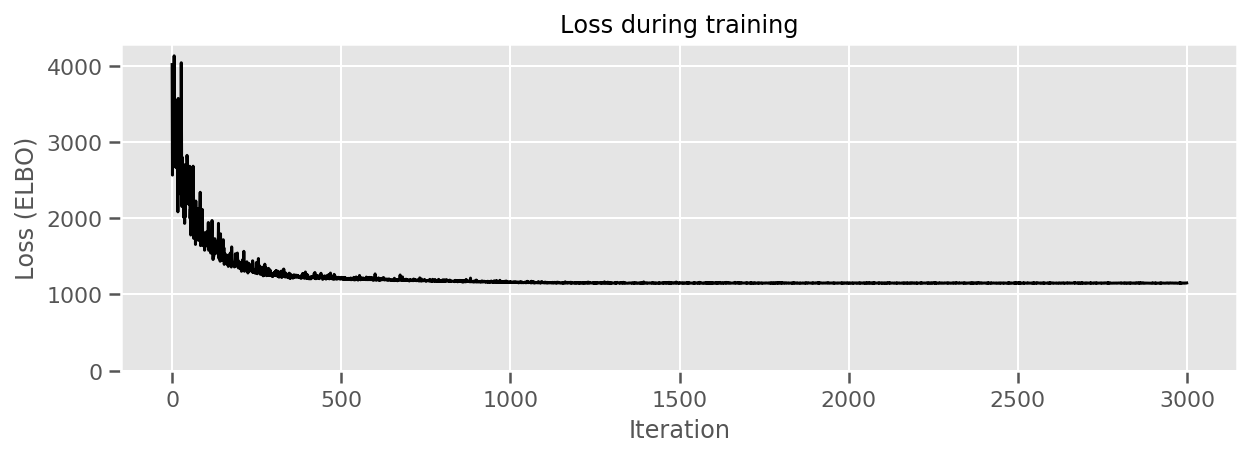

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(losses, 'k-')
ax.set(xlabel="Iteration",
       ylabel="Loss (ELBO)",
       title="Loss during training",
       ylim=0);

We can plot the estimated mean county effects, along with the uncertainty of that mean. We have ordered this by number of observations, with the largest on the left. Notice that the uncertainty is small for the counties with many observations, but is larger for the counties that have only one or two observations.

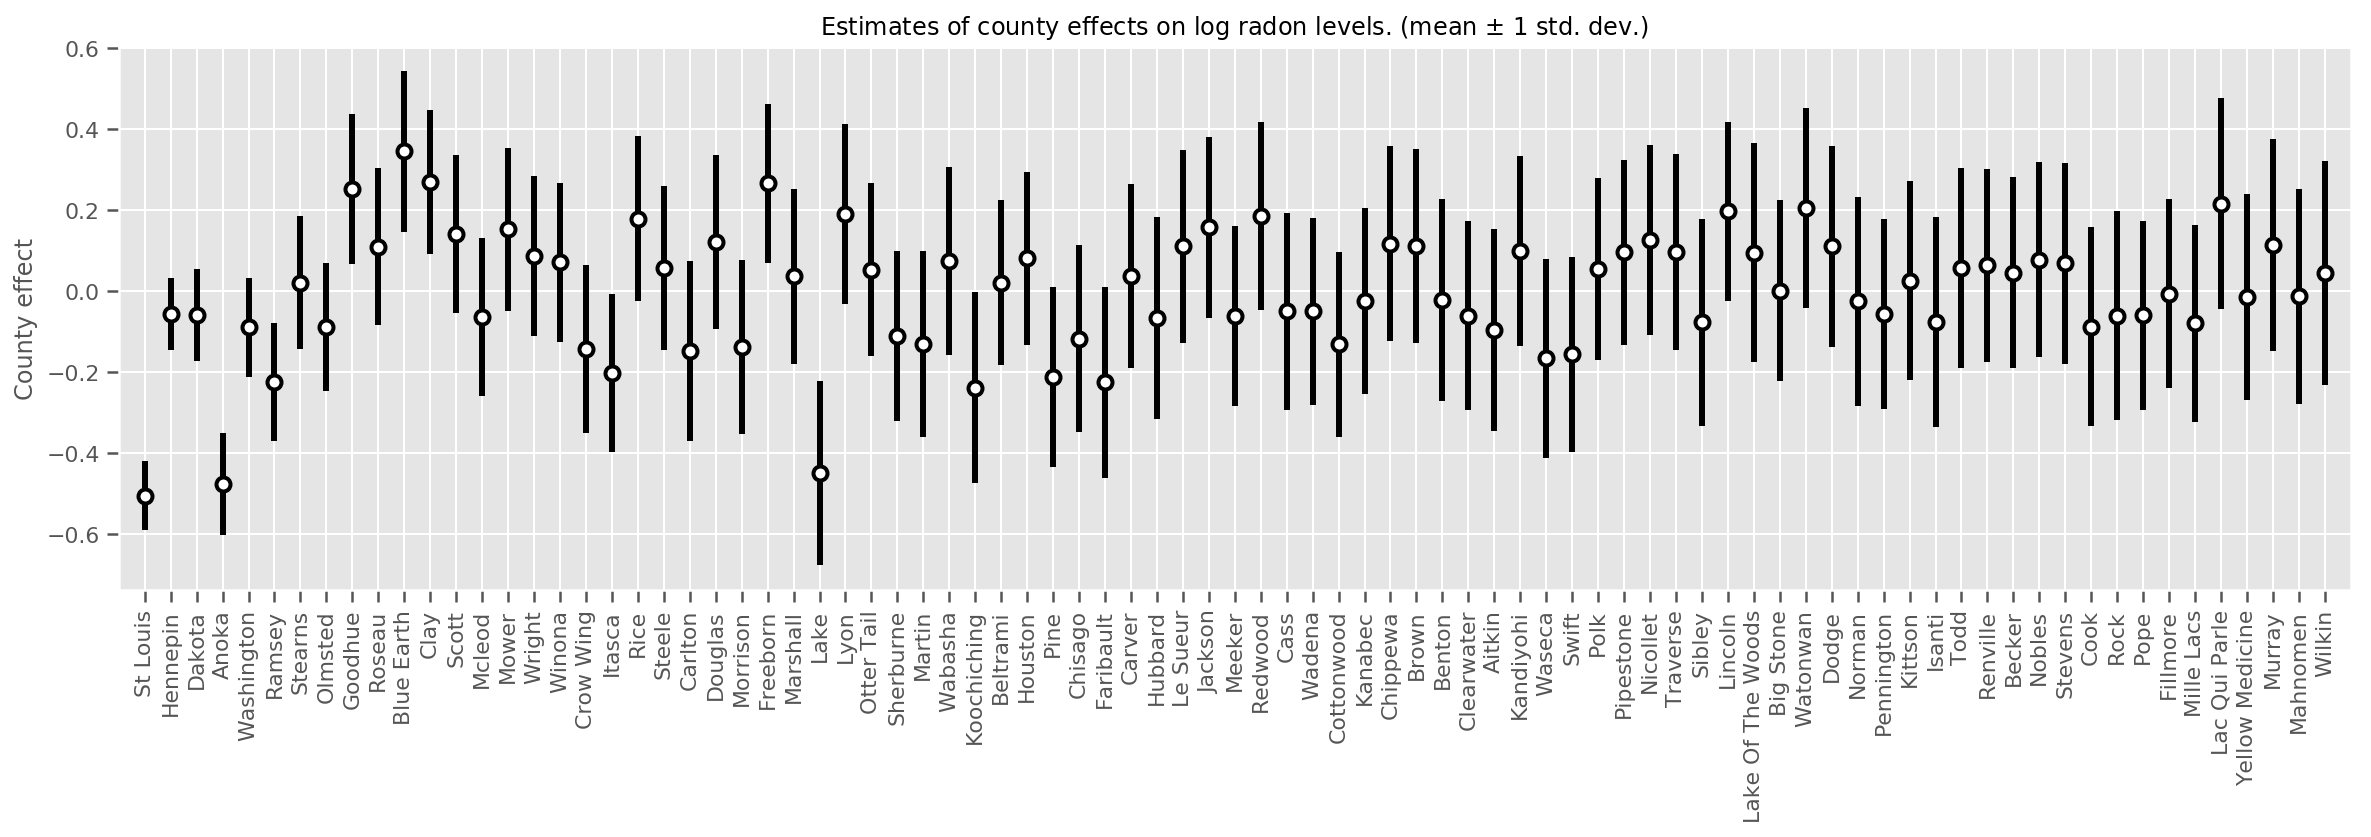

In [ ]:
county_counts = (df.groupby(by=['county', 'county_code'], observed=True)
                   .agg('size')
                   .sort_values(ascending=False)
                   .reset_index(name='count'))

means = county_weights_.mean()
stds = county_weights_.stddev()

fig, ax = plt.subplots(figsize=(20, 5))

for idx, row in county_counts.iterrows():
  mid = means[row.county_code]
  std = stds[row.county_code]
  ax.vlines(idx, mid - std, mid + std, linewidth=3)
  ax.plot(idx, means[row.county_code], 'ko', mfc='w', mew=2, ms=7)

ax.set(
    xticks=np.arange(len(county_counts)),
    xlim=(-1, len(county_counts)),
    ylabel="County effect",
    title=r"Estimates of county effects on log radon levels. (mean $\pm$ 1 std. dev.)",
)
ax.set_xticklabels(county_counts.county, rotation=90);

Indeed, we can see this more directly by plotting the log-number of observations against the estimated standard deviation, and see the relationship is approximately linear.

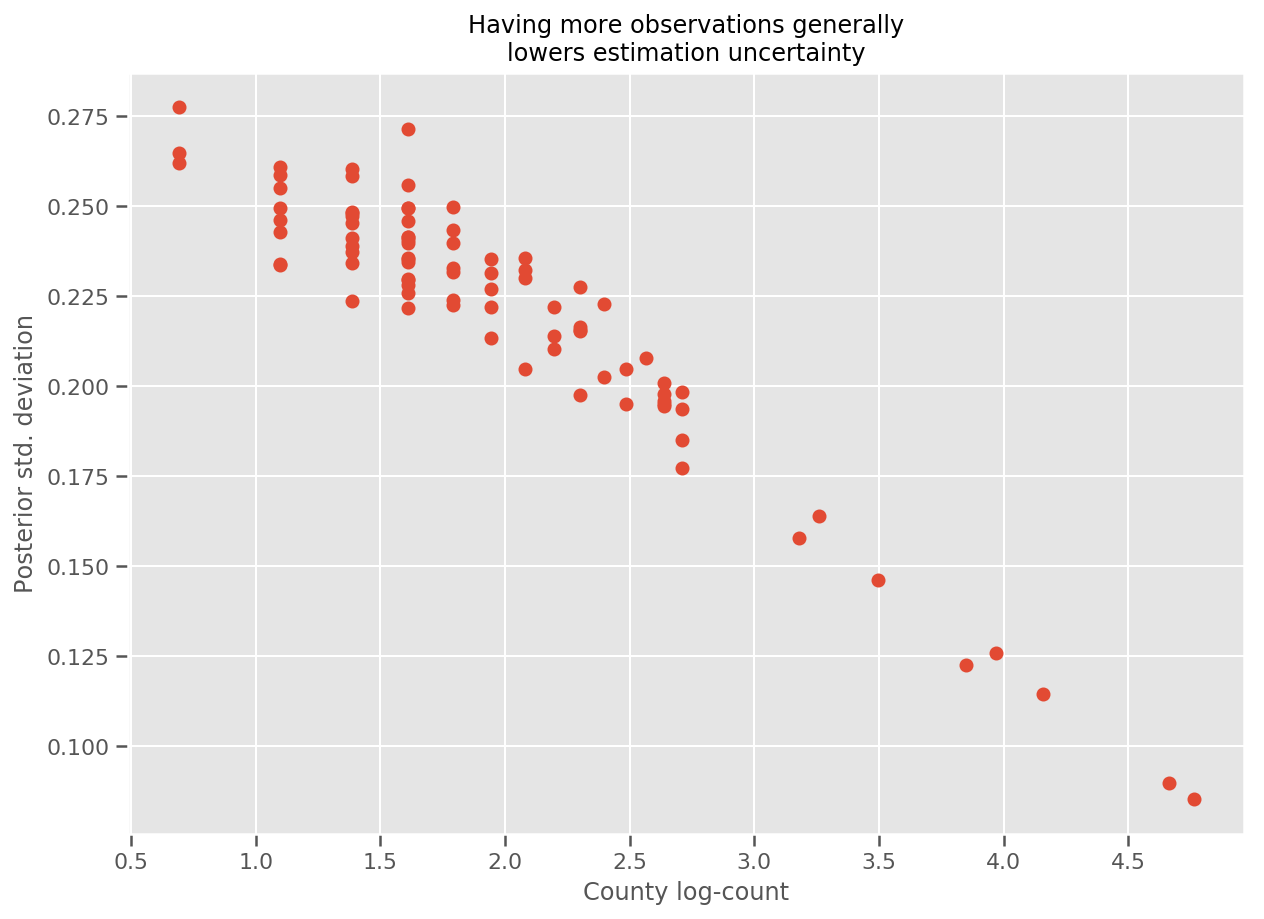

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(np.log1p(county_counts['count']), stds.numpy()[county_counts.county_code], 'o')
ax.set(
    ylabel='Posterior std. deviation',
    xlabel='County log-count',
    title='Having more observations generally\nlowers estimation uncertainty'
);


## Comparing to `lme4` in R

In [ ]:
%%shell
exit  # Trick to make this block not execute.

radon = read.csv('srrs2.dat', header = TRUE)
radon = radon[radon$state=='MN',]
radon$radon = ifelse(radon$activity==0., 0.1, radon$activity)
radon$log_radon = log(radon$radon)

# install.packages('lme4')
library(lme4)
fit <- lmer(log_radon ~ 1 + floor + (1 | county), data=radon)
fit

# Linear mixed model fit by REML ['lmerMod']
# Formula: log_radon ~ 1 + floor + (1 | county)
#    Data: radon
# REML criterion at convergence: 2171.305
# Random effects:
#  Groups   Name        Std.Dev.
#  county   (Intercept) 0.3282
#  Residual             0.7556
# Number of obs: 919, groups:  county, 85
# Fixed Effects:
# (Intercept)        floor
#       1.462       -0.693

The following table summarizes the results.

In [ ]:
print(pd.DataFrame(data=dict(intercept=[1.462, tf.reduce_mean(intercept_.mean()).numpy()],
                             floor=[-0.693, tf.reduce_mean(floor_weight_.mean()).numpy()],
                             scale=[0.3282, tf.reduce_mean(scale_prior_.sample(10000)).numpy()]),
                   index=['lme4', 'vi']))

      intercept   floor     scale
lme4   1.462000 -0.6930  0.328200
vi     1.435284 -0.6702  0.287251


This table indicates the VI results are within ~10% of `lme4`'s.  This is somewhat surprising since:
- `lme4` is based on [Laplace's method](https://www.jstatsoft.org/article/view/v067i01/) (not VI),
- no effort was made in this colab to actually converge,
- minimal effort was made to tune hyperparameters,
- no effort was taken regularize or preprocess the data (eg, center features, etc.).

## Conclusion

In this colab we described Generalized Linear Mixed-effects Models and showed how to use variational inference to fit them using TensorFlow Probability. Although the toy problem only had a few hundred training samples, the techniques used here are identical to what is needed at scale.